In [1]:
write_images = False


wirte_output_txt = False 
# Specify everytime Simulation is called 
# WARNING --> Set to False when running more then 10 simulations 
#            (otherwise it will be super slow and might crash)

In [2]:
import numpy as np

In [3]:
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

import matplotlib.pyplot as plt
import mlai.plot as plot

In [4]:
%run Missile_utils.ipynb

In [5]:
simulation_output = 'range' # For now only this is implemented
# We divide by 1000 to avoid dealing with too large numbers

In [6]:
run_grid_simulation = True # If true takes much longer and does 3D plots and so on for MODEL with 2 FEATS


We consider missiles with only 1 stage

In [7]:

basic_param_spaces = {
    'payload':  [10, 2410],
    'missilediam':  [0.1, 9.9],
    'rvdiam':  [0.1, 9.9],
    'estrange': [100, 4900], 
    'fuelmass': [500, 6000], # [500, 7000], 
    'drymass':  [1000, 3000],
    'Isp0':  [100, 800],# [100, 800],
    'thrust0':  [10000, 69000],
}

In [8]:
from sklearn.metrics import mean_squared_error
import math

# TODO: improve considering also the variance 
# (i.e. penalise less if mean prediction is not accurate, but still within 2 std dev?)
def compute_rmse(y_actual, y_predicted):
    MSE = mean_squared_error(y_actual, y_predicted)
    RMSE = math.sqrt(MSE)
 
    return RMSE

def evaluate_prediction(y_actual, y_predicted):
    return compute_rmse(y_actual, y_predicted)
    
    

# 1. Two params

In [9]:
m2_param_1 = 'fuelmass'
m2_domain_param_1 = basic_param_spaces[m2_param_1] # [500, 6000] # [5000,15000]
m2_param_2 = 'Isp0'
m2_domain_param_2 = basic_param_spaces[m2_param_2] # [200, 300] # [224, 228]

m2_space = ParameterSpace(
          [ContinuousParameter(m2_param_1, *m2_domain_param_1), 
           ContinuousParameter(m2_param_2, *m2_domain_param_2),
#            ContinuousParameter(param_3, *domain_param_3),
#            ContinuousParameter(param_4, *domain_param_4)
          ])

custom_param_names = [m2_param_1, m2_param_2]

In [10]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION (Re-run since custom_param_names has changed)
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
                
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y


## 1. Experimental design

Experimental design addresses the problem of how to collect data points (experiments) to better control certain sources of variance of a model.

In experimental design the goal is to decide at which locations of the input space we should evaluate a function of interest. In some contexts it is also known as active learning, for instance in image classification problems in which more labels need to be collected.

The are two main ways of doing experimental design.

1. Model-free designs: These designs define rules to spread the experiments as much as possible across the input domain. Drawing points at random or in a grid are the most naive way of doing so. Other more elaborate approaches are low discrepancy sequences that try to induce some negative correlation in the selected points to spread them evenly. Some examples are Latin hyper-cube sampling and Sobol sequences.

2. Model-based designs: In these designs a feedback loop is used between some ‘optimal’ statistical criterion to collect points and a model. In general, the criterion aims to reduce some type of variance in the model. The type of optimality refers to which type of uncertainty that is reduced. For instance, a D-optimal design aims to maximize the differential Shannon information content of the model parameter estimates; an I-optimal design seeks to minimize the average prediction variance over the entire design space. 

Gaussian processes have a long tradition of being the ‘model of choice’ for designing experiments.

### Use model-free experimental design to start
 (RandomDesign or Latin Design)


New simulation 

fuelmass: 1343.0293803714767
Isp0: 115.74524540246517


Stage 1 burnout
Velocity (km/s):  0.466991531284308
Angle (deg h):  43.71231382720713
Range (km):  1.548886630127455
Time (sec):  16.999999999999975
Final results: 
Range (km):  26.72799825535769
Apogee (km):  8.465570413968793
Time to target (sec):  91.69999999999906




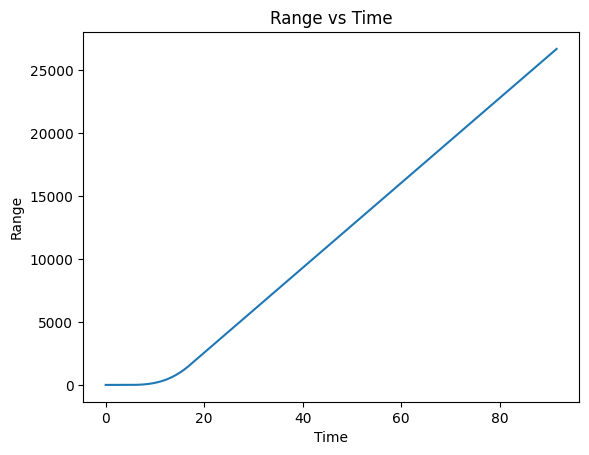

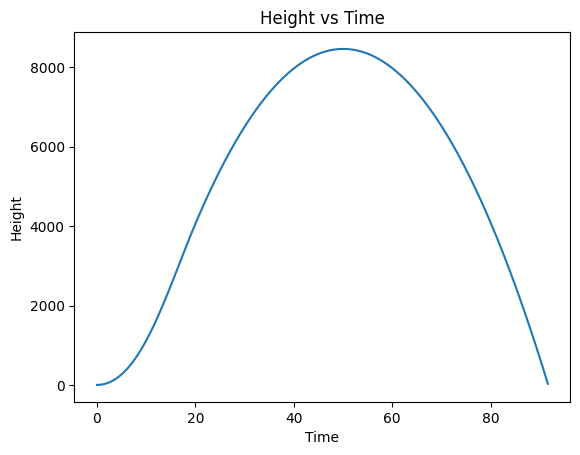

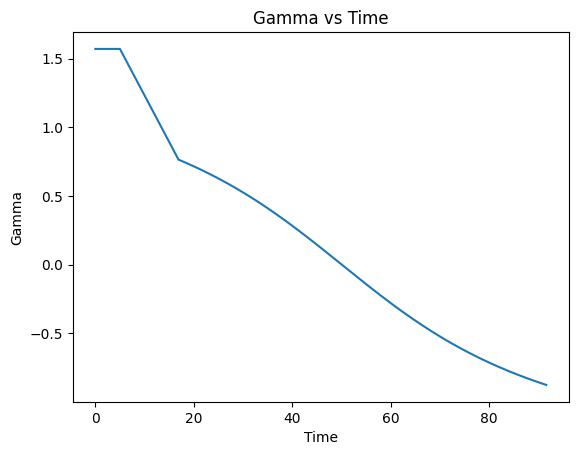

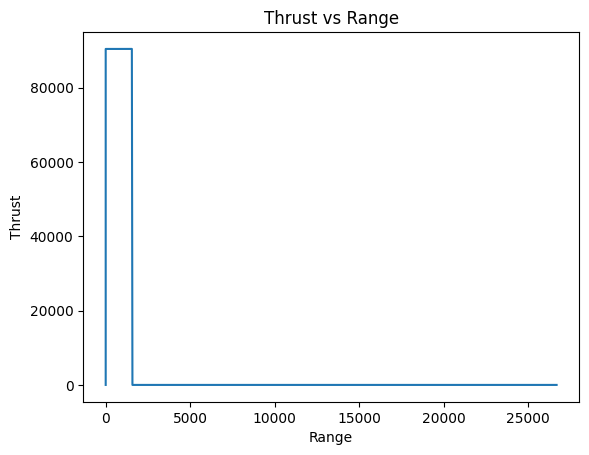

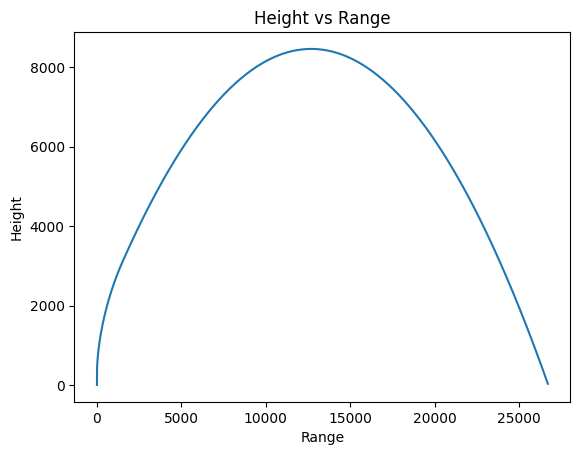

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 4395.034857388593
Isp0: 437.195620950855


Stage 1 burnout
Velocity (km/s):  4.125527811723928
Angle (deg h):  43.66048678382085
Range (km):  143.1830411018647
Time (sec):  209.3999999999924
Final results: 
Range (km):  2431.645422077911
Apogee (km):  773.3933915798401
Time to target (sec):  1082.7000000001108




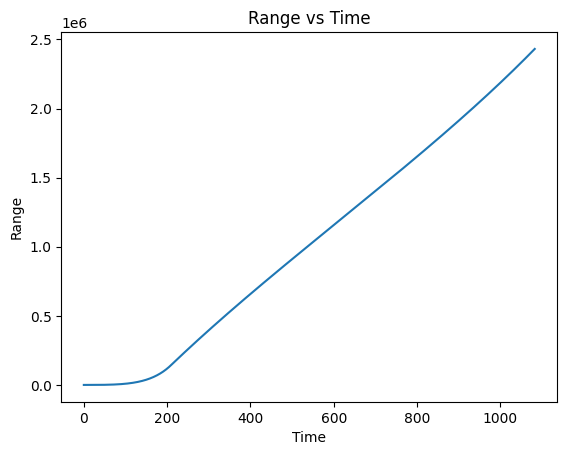

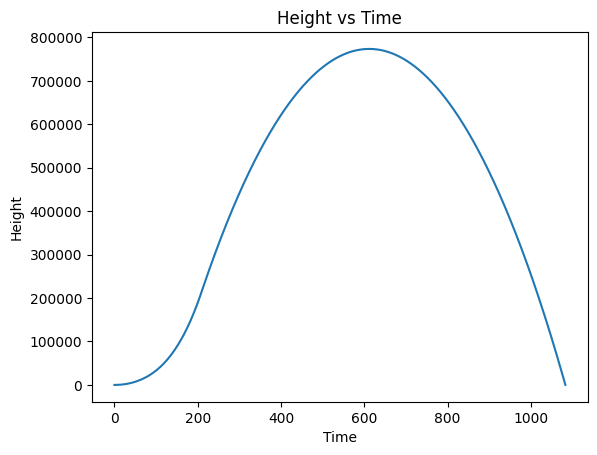

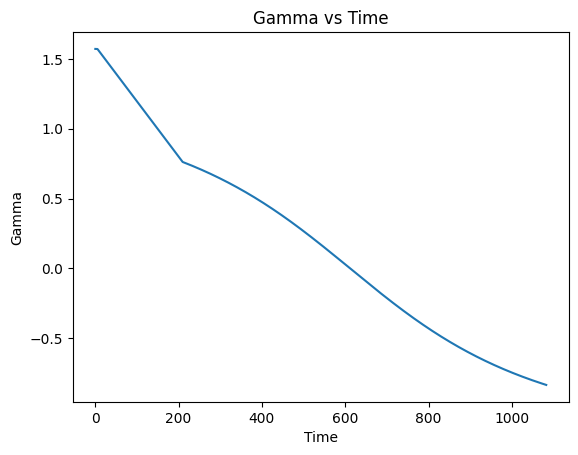

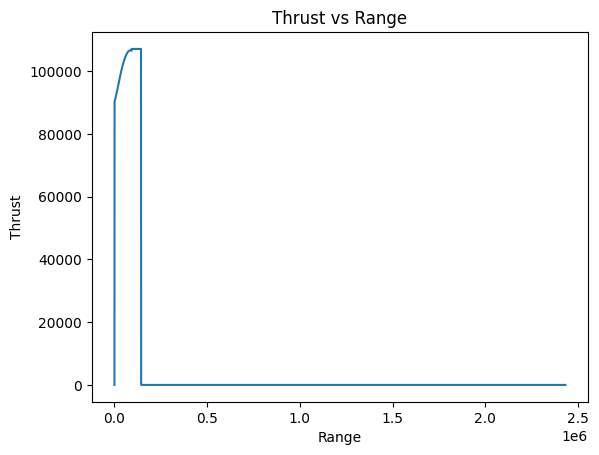

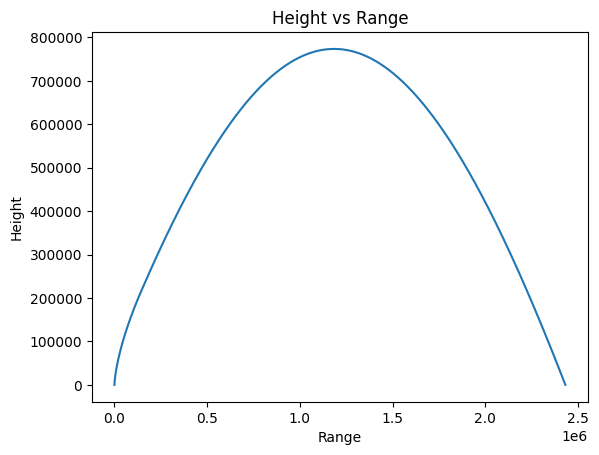

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 2862.39844503585
Isp0: 731.486783583656


Stage 1 burnout
Velocity (km/s):  5.913003521867593
Angle (deg h):  43.65831509717636
Range (km):  246.5819483438078
Time (sec):  228.19999999999132
Final results: 
Range (km):  5803.206998608573
Apogee (km):  2040.9206507360004
Time to target (sec):  2038.0999999992418




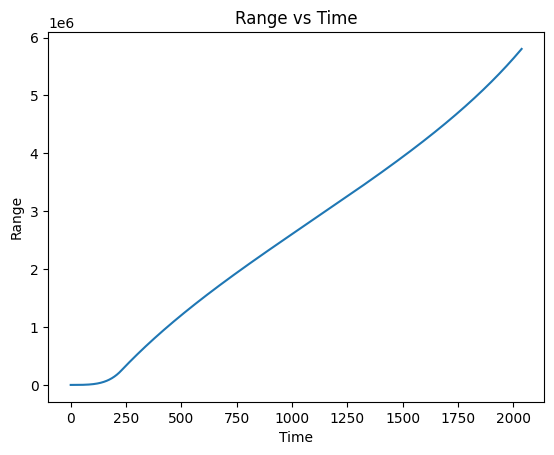

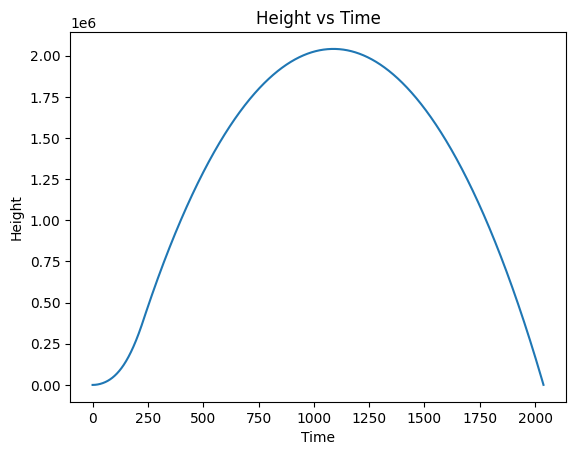

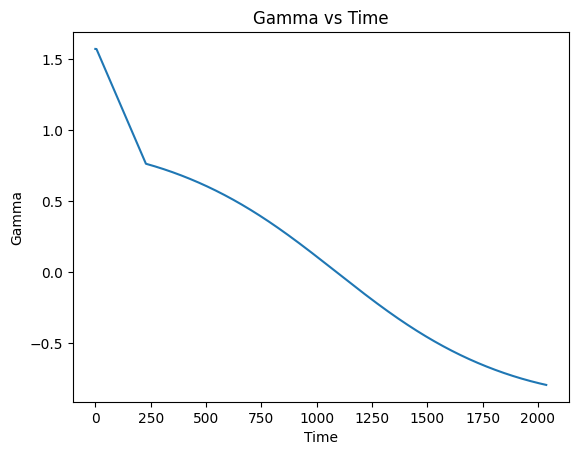

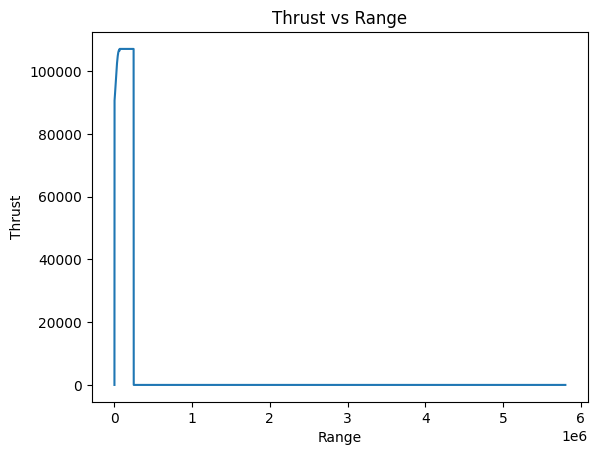

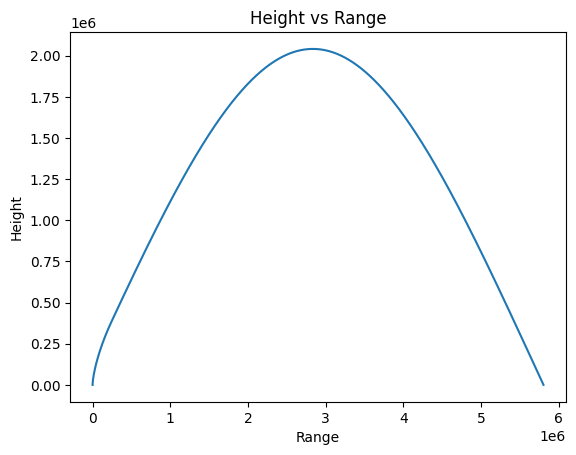

Data written to 'results/results_2.txt'

New simulation 

fuelmass: 4553.824295632359
Isp0: 501.7968244770639


Stage 1 burnout
Velocity (km/s):  4.9278021724344
Angle (deg h):  43.66372124457481
Range (km):  200.98457198092706
Time (sec):  248.99999999999014
Final results: 
Range (km):  3712.780715929472
Apogee (km):  1222.333889500634
Time to target (sec):  1455.6999999997715




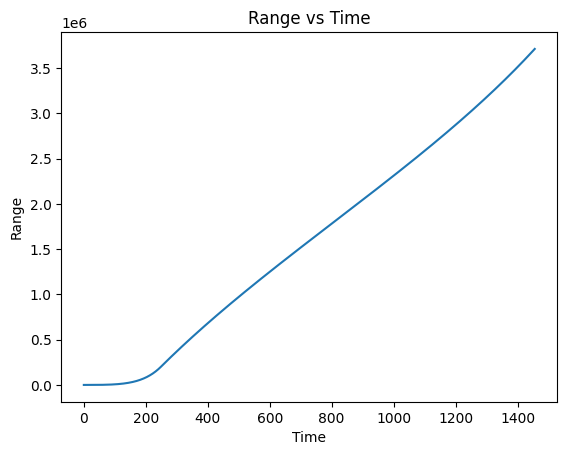

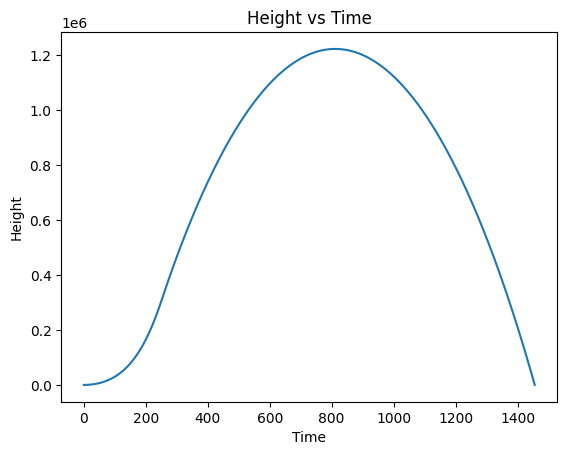

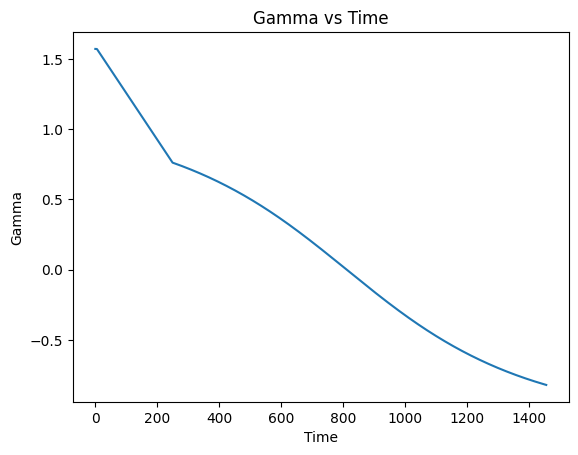

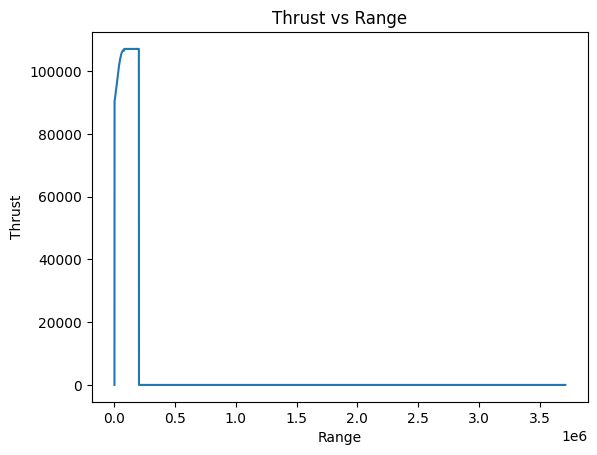

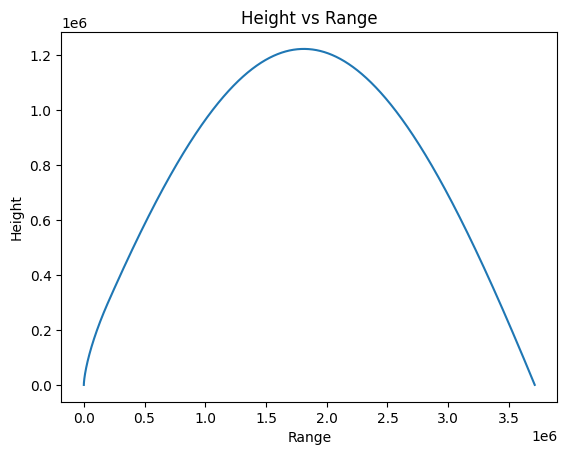

Data written to 'results/results_3.txt'

New simulation 

fuelmass: 934.6740689761409
Isp0: 399.5065398861507


Stage 1 burnout
Velocity (km/s):  1.161830851616492
Angle (deg h):  43.7307908537233
Range (km):  10.367609734911424
Time (sec):  40.70000000000031
Final results: 
Range (km):  167.14473126576019
Apogee (km):  52.18890992900064
Time to target (sec):  229.09999999999127




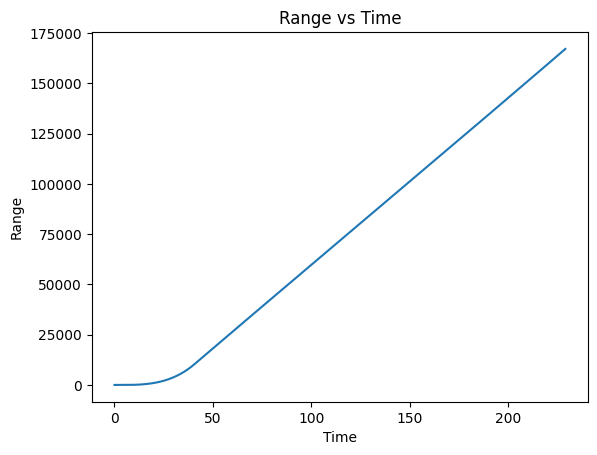

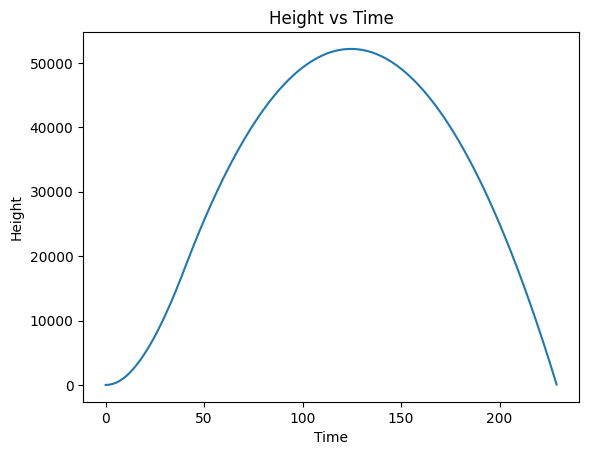

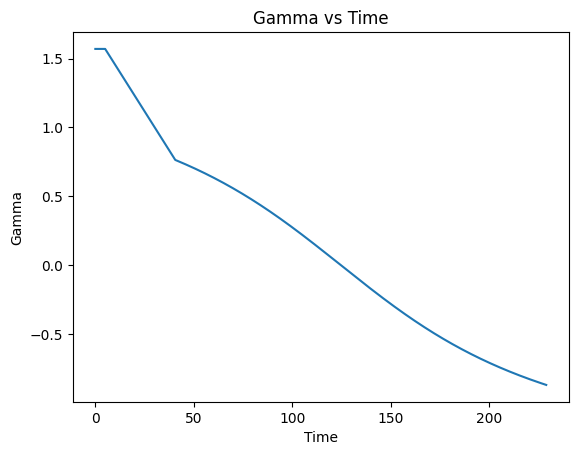

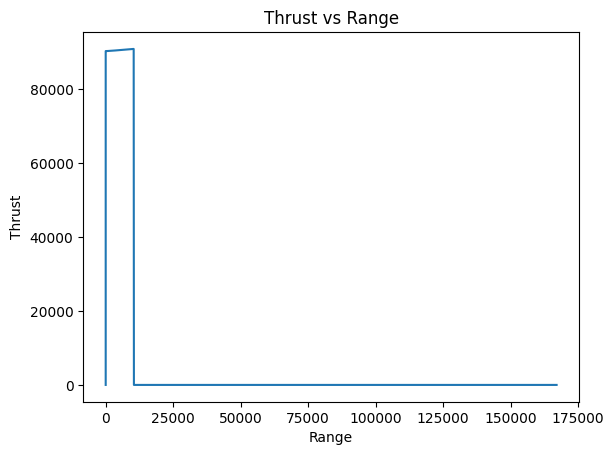

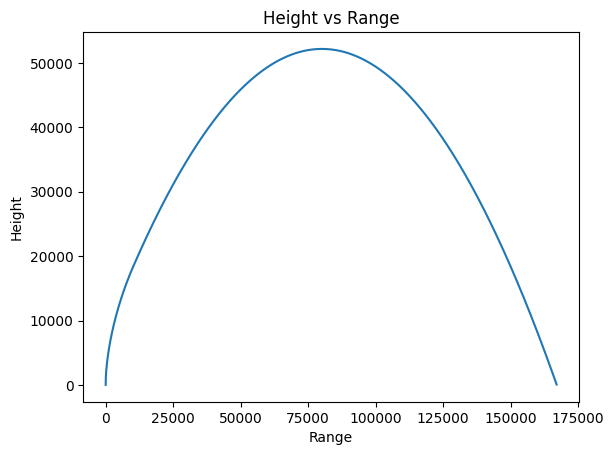

Data written to 'results/results_4.txt'

New simulation 

fuelmass: 5513.8536567979045
Isp0: 628.4961033210212


Stage 1 burnout
Velocity (km/s):  6.862894911265385
Angle (deg h):  43.65147400845683
Range (km):  394.9240261142111
Time (sec):  377.60000000001736
Final results: 
Range (km):  8955.924011261142
Apogee (km):  3699.96400188816
Time to target (sec):  3375.899999998025




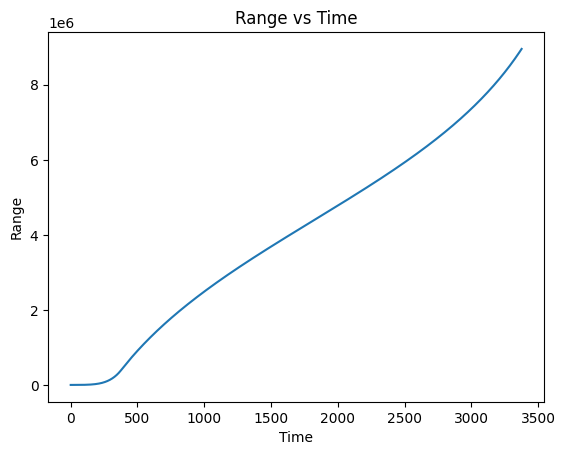

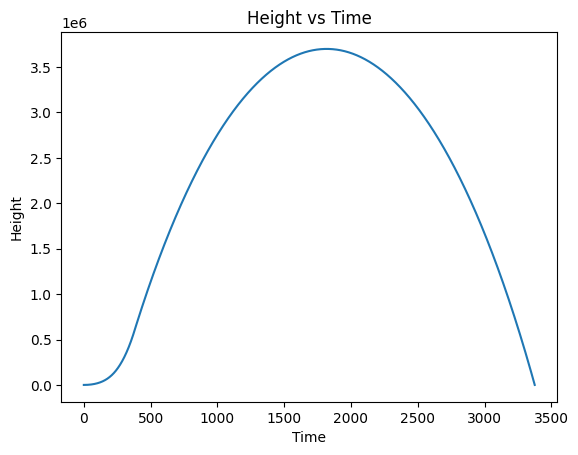

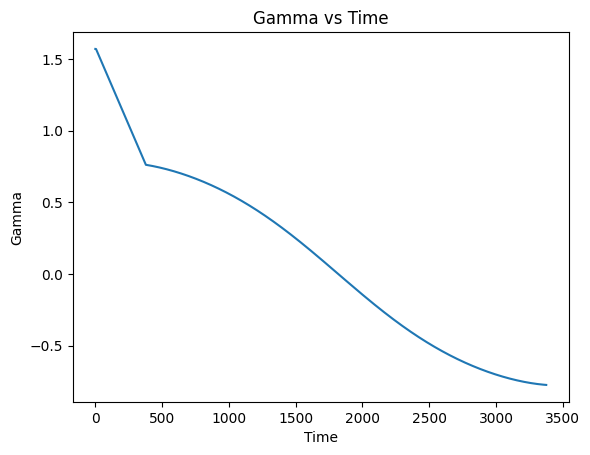

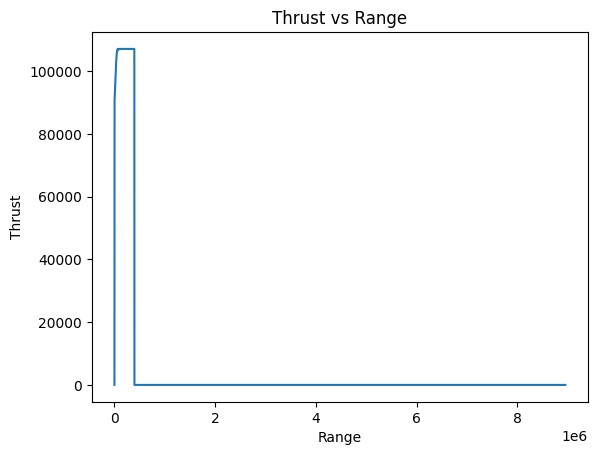

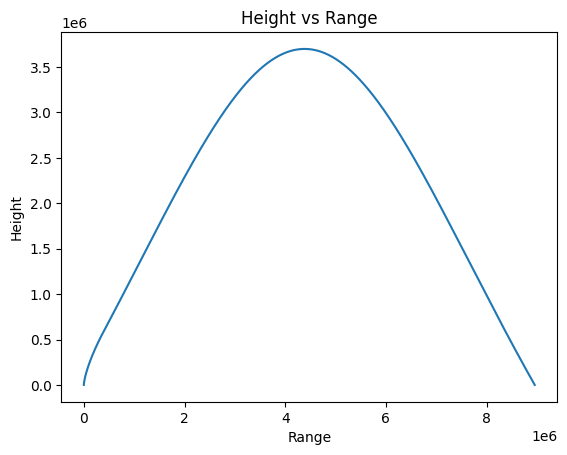

Data written to 'results/results_5.txt'


In [11]:
wirte_output_txt = True


# from emukit.core.initial_designs.latin_design import LatinDesign
# design = LatinDesign(parameter_space) 

m2_design = RandomDesign(m2_space)
m2_x = m2_design.get_samples(3*2)
m2_y = run_missile_sim(m2_x)

In [12]:
# Build model
m2_var_kernel = (100)**2 
m2_lengthscale = 100 # 100 # 1
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
m2_var_noise = 1e-5 # small value
# In catapult: 1e-5

#kern = GPy.kern.RBF(input_dim=2, lengthscale=lengthscale, variance =var_kernel)  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)

constrain_lengthscale = True

m2_rbf_kern = GPy.kern.RBF(input_dim=2, lengthscale=m2_lengthscale)
if constrain_lengthscale:
    m2_rbf_kern.lengthscale.constrain_bounded(m2_lengthscale, m2_lengthscale*1e12)

# m2_kern = m2_rbf_kern + \
#     GPy.kern.Linear(input_dim=2)
m2_kern = (GPy.kern.RBF(input_dim=2, lengthscale=500) * \
           GPy.kern.RBF(input_dim=2, lengthscale=100)) * \
    GPy.kern.Linear(input_dim=2)
# m2_kern = m2_rbf_kern

m2_model_gpy = GPRegression(m2_x,m2_y, kernel=m2_kern)
m2_model_gpy.kern.variance =  m2_var_kernel 
m2_model_gpy.likelihood.variance.fix(m2_var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(m2_model_gpy)




reconstraining parameters rbf.lengthscale


GP_regression.,value,constraints,priors
mul.rbf.variance,1.0,+ve,
mul.rbf.lengthscale,500.0,+ve,
mul.rbf_1.variance,1.0,+ve,
mul.rbf_1.lengthscale,100.0,+ve,
mul.linear.variances,1.0,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [13]:
# m2_model_gpy_opt = m2_model_gpy
# m2_model_gpy_opt.optimize()
# m2_model_gpy_opt.plot()

In [14]:
m2_model_emukit = GPyModelWrapper(m2_model_gpy)
m2_model_emukit.optimize()

In [15]:
display(m2_model_gpy)

GP_regression.,value,constraints,priors
mul.rbf.variance,1.0889617143548749,+ve,
mul.rbf.lengthscale,822.8964379555363,+ve,
mul.rbf_1.variance,1.0889617771085007,+ve,
mul.rbf_1.lengthscale,15070.332215222019,+ve,
mul.linear.variances,1.0889617270777847,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [16]:
# Create data for plot
wirte_output_txt = False
nr_points_plot = 101
m2_param_1_x_plot = np.linspace(m2_space.parameters[0].min, m2_space.parameters[0].max, nr_points_plot)[:, None]
m2_param_2_x_plot = np.linspace(m2_space.parameters[1].min, m2_space.parameters[1].max, nr_points_plot)[:, None]
m2_x_plot_mesh, m2_y_plot_mesh = np.meshgrid(m2_param_1_x_plot, m2_param_2_x_plot)
m2_x_plot = np.array([m2_x_plot_mesh, m2_y_plot_mesh]).T.reshape(-1,2)


# TEMP read data from txt
# np.savetxt('test1.txt', a, fmt='%f')
m2_y_plot = np.loadtxt('m2_y_plot.txt', dtype=float)[:,None]

if run_grid_simulation:
#     m2_y_plot = run_missile_sim(m2_x_plot) # TAKES LONG TIME    
    m2_Z = m2_y_plot.reshape(m2_x_plot_mesh.shape)




In [17]:
# Compute current prediction
m2_mu_plot_grid_pred1, var_plot_grid_pred1 = m2_model_emukit.predict(m2_x_plot)
m2_mu_plot_pred1 = m2_mu_plot_grid_pred1.reshape(m2_x_plot_mesh.shape)
m2_var_plot_pred1 = var_plot_grid_pred1.reshape(m2_x_plot_mesh.shape)

if run_grid_simulation:
    m2_rmse = evaluate_prediction(y_actual=m2_y_plot, y_predicted=m2_mu_plot_grid_pred1)
    print("RMSE m2 (before experiment design loop): ", m2_rmse)


RMSE m2 (before experiment design loop):  3300.160958075024


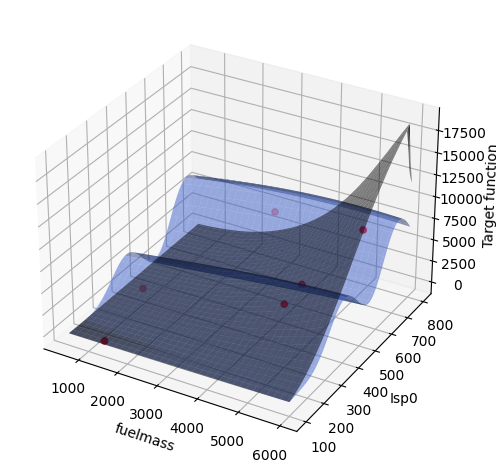

In [18]:
if run_grid_simulation:
    # 3D Plot
    add_bands = False


    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # True surface
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_Z, 
                           alpha = .5, 
                           label='target function',
                           color='black'
                          )
    # Mean predicted
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1, 
                           alpha = .5, 
                           label='model', # Mean
                           color='royalblue'
                          )
    # True points observed
    ax.scatter(m2_x[:,0], m2_x[:,1], m2_y, marker='o', color='red')

    if add_bands:
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1-2*m2_var_plot_pred1, 
                               alpha = .5, 
                               label='model_ci_lb', # Confidence band lower bound
                               color='lightskyblue'
                              )
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1+2*m2_var_plot_pred1, 
                               alpha = .5, 
                               label='model_ci_ub', # Confidence band upper bound
                               color='lightskyblue' 
                              )
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    ax.set_zlabel('Target function')
    plt.tight_layout()



 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_636/1125577198.py:53: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_636/1125577198.py:62: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_636/1125577198.py:75: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


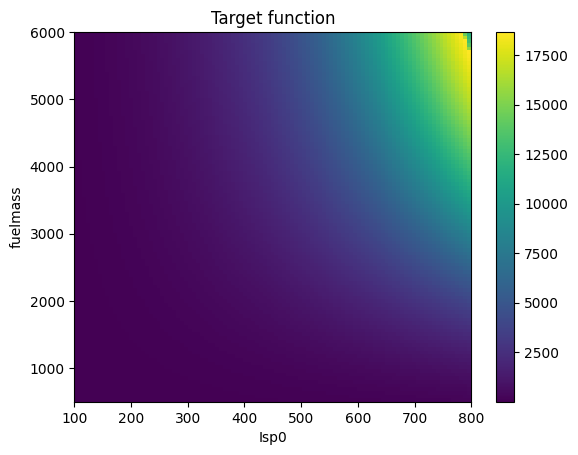

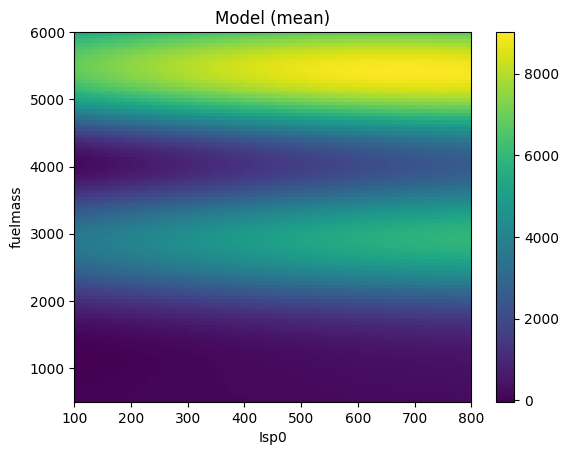

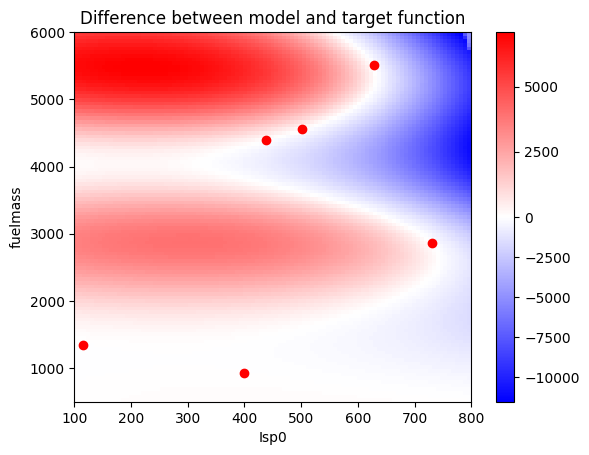

In [19]:
if run_grid_simulation:
    from matplotlib import colors
    divnorm=colors.TwoSlopeNorm(vcenter=0.) # vmin=-5., vcenter=0., vmax=10

#     # NORMAL
#     ## Heatmaps
#     extents = [m2_space.parameters[0].min, m2_space.parameters[0].max, 
#                m2_space.parameters[1].min, m2_space.parameters[1].max]

#     # True values
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_Z, extent=extents, aspect='auto')
#     ax.set_title('Target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()

#     # Model
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred1, extent=extents, aspect='auto')
#     ax.set_title('Model (mean)')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()


#     # Difference
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred1-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm)
#     ax.set_title('Difference between model and target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     # Add points where simulation evaluated
#     ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
# #     ax.plot(m2_x[:,1], m2_x[:,0], 'ro')
#     fig.colorbar(im, ax=ax)
#     fig.show()

    # REVERSE
    ## Heatmaps
    extents = [m2_space.parameters[1].min, m2_space.parameters[1].max, 
               m2_space.parameters[0].min, m2_space.parameters[0].max]

    # True values
    fig, ax = plt.subplots()
    im = ax.imshow(m2_Z, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()

    # Model
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred1, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Model (mean)')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()


    # Difference
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred1-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm, origin='lower')
    ax.set_title('Difference between model and target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    # Add points where simulation evaluated
#     ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
    ax.plot(m2_x[:,1], m2_x[:,0], 'ro')
    fig.colorbar(im, ax=ax)
    fig.show()



In [20]:
m2_x

array([[1343.02938037,  115.7452454 ],
       [4395.03485739,  437.19562095],
       [2862.39844504,  731.48678358],
       [4553.82429563,  501.79682448],
       [ 934.67406898,  399.50653989],
       [5513.8536568 ,  628.49610332]])

### Use the model created for model-based experiment design
use the model to decide which are the best points to collect using some data collection criteria (that we call acquisition).

In [21]:
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance


In [22]:
# help(ExperimentalDesignLoop)

 It is known that when using Gaussian processes, selecting points of maximum variance is equivalent to maximizing the mutual information between the model and the new set of points so using ModelVariance is a simple but mathematically grounded approach.
 
 Actually in this example we use IVR

In [23]:
m2_2_model_emukit = m2_model_emukit

In [24]:
wirte_output_txt = False

integrated_variance = IntegratedVarianceReduction(space=m2_space,
                                                  model=m2_2_model_emukit)
m2_ed = ExperimentalDesignLoop(space=m2_space, 
                            model=m2_2_model_emukit, 
                            acquisition = integrated_variance,
                            batch_size = 1) 
# bach size is set to one in this example as we’ll collect evaluations 
# sequentially but parallel evaluations are allowed
# m2_ed.run_loop(user_function=run_missile_sim, stopping_condition=5*2)
m2_ed.run_loop(user_function=run_missile_sim, stopping_condition=10*2)



 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



New simulation 

fuelmass: 5494.756080337225
Isp0: 243.638660548447


Stage 1 burnout
Velocity (km/s):  2.214203009680635
Angle (deg h):  43.65829619268055
Range (km):  51.22252335274359
Time (sec):  145.899999999996
Final results: 
Range (km):  647.6706673528903
Apogee (km):  204.8258968182043
Time to target (sec):  531.1000000000522



New simulation 

fuelmass: 3573.1895722029426
Isp0: 438.4366493563891


Stage 1 burnout
Velocity (km/s):  3.7056626747893704
Angle (deg h):  43.65187510514112
Range (km):  111.02253826109813
Time (sec):  170.6999999999946
Final results: 
Range (km):  1893.1688250912673
Apogee (km):  593.0364800610199
Time to target (sec):  905.7000000001374



New simulation 

fuelmass: 5745.3611086519495
Isp0: 322.4673794768965


Stage 1 burnout
Velocity (km/s):  3.1783984047182727
Angle (deg h):  43.65833153818811
Range (km):  97.57885858934651
Time (sec):  201.89999999999281
Final results: 
Range (km):  1378.4470912189954
Apogee (km):  433.8349271419265
Time to tar

In [25]:
m2_2_model_emukit.__dict__

{'model': <GPy.models.gp_regression.GPRegression at 0x7fc250591690>,
 'n_restarts': 1}

In [26]:
m2_ed.__dict__

{'candidate_point_calculator': <emukit.core.loop.candidate_point_calculators.SequentialPointCalculator at 0x7fc290fe9660>,
 'model_updaters': [<emukit.core.loop.model_updaters.FixedIntervalUpdater at 0x7fc260bef0d0>],
 'loop_state': <emukit.core.loop.loop_state.LoopState at 0x7fc2505424a0>,
 'loop_start_event': Event([]),
 'iteration_end_event': Event([]),
 'model': <emukit.model_wrappers.gpy_model_wrappers.GPyModelWrapper at 0x7fc250778bb0>}

In [27]:
if run_grid_simulation:
    # Compute new prediction
    m2_mu_plot_grid_pred2, var_plot_grid_pred2 = m2_2_model_emukit.predict(m2_x_plot)
    m2_mu_plot_pred2 = m2_mu_plot_grid_pred2.reshape(m2_x_plot_mesh.shape)
    m2_var_plot_pred2 = var_plot_grid_pred2.reshape(m2_x_plot_mesh.shape)
    
    m2_2_rmse = evaluate_prediction(y_actual=m2_y_plot, y_predicted=m2_mu_plot_grid_pred2)
    print("RMSE m2 (post experiment design loop): ", m2_2_rmse)




RMSE m2 (post experiment design loop):  290.37907901765715


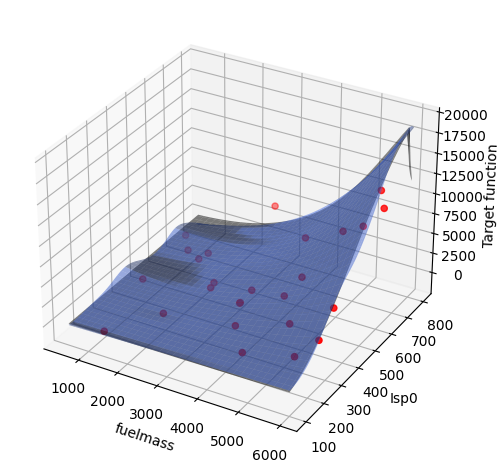

In [28]:
if run_grid_simulation:
    # 3D Plot
    add_bands = False


    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # True surface
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_Z, 
                           alpha = .5, 
                           label='target function',
                           color='black'
                          )
    # Mean predicted
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2, 
                           alpha = .5, 
                           label='model', # Mean
                           color='royalblue'
                          )
    # True points observed
    ax.scatter(np.array(m2_2_model_emukit.X)[:,0], 
               np.array(m2_2_model_emukit.X)[:,1], m2_2_model_emukit.Y, marker='o', color='red')

    if add_bands:
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2-2*m2_var_plot_pred2, 
                               alpha = .5, 
                               label='model_ci_lb', # Confidence band lower bound
                               color='lightskyblue'
                              )
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2+2*m2_var_plot_pred2, 
                               alpha = .5, 
                               label='model_ci_ub', # Confidence band upper bound
                               color='lightskyblue' 
                              )
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    ax.set_zlabel('Target function')
    plt.tight_layout()




 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_636/3906114016.py:50: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_636/3906114016.py:59: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_636/3906114016.py:73: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


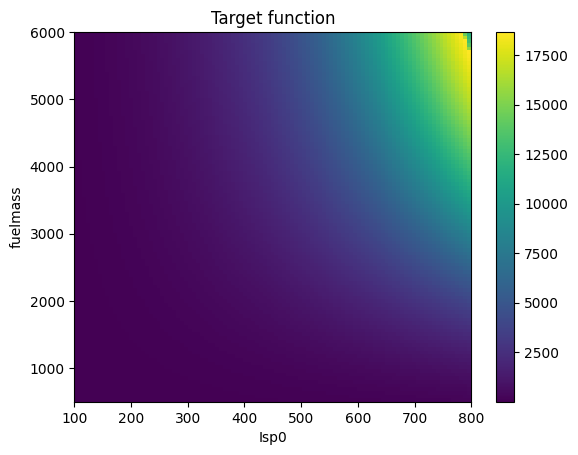

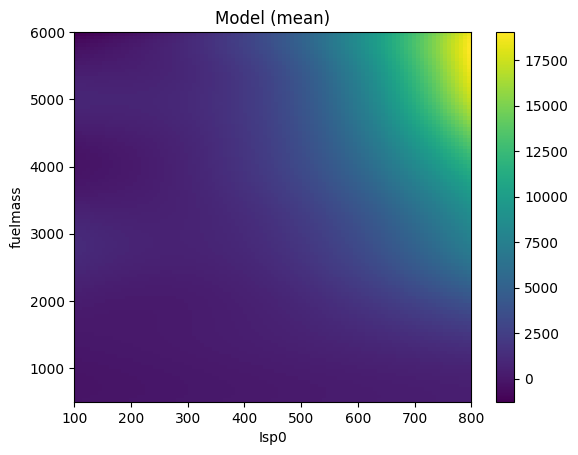

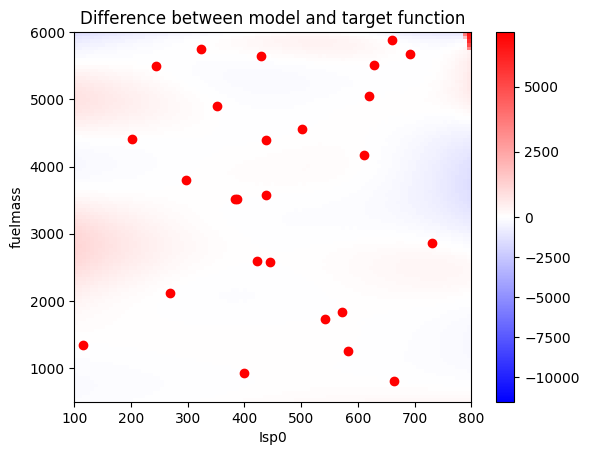

In [29]:
if run_grid_simulation:

#     ## Heatmaps
#     extents = [m2_space.parameters[0].min, m2_space.parameters[0].max, 
#                m2_space.parameters[1].min, m2_space.parameters[1].max]

#     # True values
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_Z, extent=extents, aspect='auto')
#     ax.set_title('Target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()

#     # Model
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred2, extent=extents, aspect='auto')
#     ax.set_title('Model (mean)')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()


#     # Difference
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred2-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm)
#     ax.set_title('Difference between model and target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     ax.plot(np.array(m2_2_model_emukit.X)[:,0], np.array(m2_2_model_emukit.X)[:,1], 'ro')
#     fig.colorbar(im, ax=ax)
#     fig.show()

#     # ax.plot(m2_x, m2_y, marker='o', color='red')
    
    # REVERSE
    ## Heatmaps
    extents = [m2_space.parameters[1].min, m2_space.parameters[1].max, 
               m2_space.parameters[0].min, m2_space.parameters[0].max]

    # True values
    fig, ax = plt.subplots()
    im = ax.imshow(m2_Z, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()

    # Model
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred2, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Model (mean)')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()


    # Difference
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred2-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm, origin='lower')
    ax.set_title('Difference between model and target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    # Add points where simulation evaluated
#     ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
#     ax.plot(m2_x[:,1], m2_x[:,0], 'ro')
    ax.plot(np.array(m2_2_model_emukit.X)[:,1], np.array(m2_2_model_emukit.X)[:,0], 'ro')
    fig.colorbar(im, ax=ax)
    fig.show()

